# Quick walkthrough of model development from Random Forest to poorly performing XGBoost

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFECV

from xgboost import XGBClassifier

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Tools for developing code
%load_ext autoreload 
%autoreload 2

# Add library to path 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from lib.model import kfold, f1_scorer, load_and_process_training_data
from lib.preprocessing import preprocess, run_feature_engineering
from lib.visualization import report_cv_scores
from lib.visualization import plot_learning_curve


In [4]:
X_data, y_data = load_and_process_training_data()
hh_idx = X_data.parentesco1 == 1

In [5]:
X_train = run_feature_engineering(X_data, level='medium').loc[hh_idx]
y_train = y_data.loc[hh_idx]
print(X_train.shape, y_train.shape)

(2973, 120) (2973,)


In [27]:
X_train.head()

,v2a1,tipovivi_rank,rent_by_dep,tipovivi4,tipovivi2,rent_by_people,rent_by_rooms,tipovivi5,tipovivi1,tipovivi3,...,phone_per_person_household,v14a,refrig,sanitario1,computer,television,tablet_per_person_household,v18q1,mobilephone,qmobilephone
0,190000.0,3,1000000.0,0,0,190000.0,63333.333333,0,0,1,...,1.00,1,1,0,0,0,0.00,0.0,1,1
1,135000.0,3,135000.0,0,0,135000.0,33750.000000,0,0,1,...,1.00,1,1,0,0,0,1.00,1.0,1,1
2,0.0,2,0.0,0,0,0.0,0.000000,0,1,0,...,0.00,1,1,0,0,0,0.00,0.0,0,0
5,180000.0,3,180000.0,0,0,45000.0,36000.000000,0,0,1,...,0.75,1,1,0,0,0,0.25,1.0,1,3
8,130000.0,3,130000.0,0,0,32500.0,65000.000000,0,0,1,...,0.25,1,1,0,0,0,0.00,0.0,1,1


In [6]:
transformer_pipeline = Pipeline(steps=[
                        ('imputer', Imputer(strategy='mean')),
                        ('feature_scaler', StandardScaler()),
                        ])

pipeline = Pipeline(steps=[
    ('imputer', Imputer(strategy='mean')),
    ('feature_scaler', StandardScaler()),
    ('random_forest', RandomForestClassifier(random_state=1))])

DEPTHS = [5, 10, 15, 20, 25, 30, 35, 40]
param_grid = dict(random_forest__max_depth=DEPTHS)

In [57]:
%%time
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.359 (std: 0.036)
Parameters: {'random_forest__max_depth': 15}

Model with rank: 2
Mean validation score: 0.339 (std: 0.030)
Parameters: {'random_forest__max_depth': 10}

Model with rank: 3
Mean validation score: 0.337 (std: 0.043)
Parameters: {'random_forest__max_depth': 30}

Model with rank: 3
Mean validation score: 0.337 (std: 0.043)
Parameters: {'random_forest__max_depth': 35}

Model with rank: 3
Mean validation score: 0.337 (std: 0.043)
Parameters: {'random_forest__max_depth': 40}

Wall time: 5.31 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

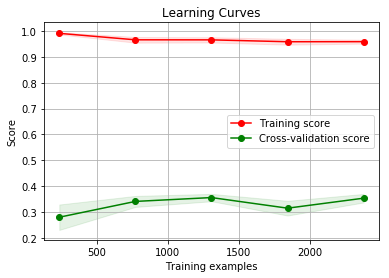

In [58]:
model = grid.best_estimator_
model.fit(X_train, y_train)
plot_learning_curve(model, 'Learning Curves', X_train, y_train, cv=kfold, scoring=f1_scorer)

In [59]:
estimator = model.steps[-1][1]

# WARNING - need to fix for automated feature selection, as column names/orders are not preserved
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': estimator.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
feature_importances[:20]

,feature,importance
10,meaneduc,0.051422
22,meaneduc_mean,0.046026
110,phone_per_person_household,0.034173
39,age,0.030343
12,educ_rank,0.024441
105,female_per_room,0.022261
11,escolari,0.020897
68,utility_rank_sum,0.020299
109,house_utility_vulnerability,0.019657
104,male_per_room,0.019608


In [60]:
X_transformed = transformer_pipeline.fit_transform(X_train)
rf = RandomForestClassifier(random_state=1, max_depth=30)
feature_selector = RFECV(rf, step = 0.02, cv = kfold, scoring=f1_scorer, n_jobs = -1)

feature_selector.fit(X_transformed, y_train)
n_features = feature_selector.n_features_

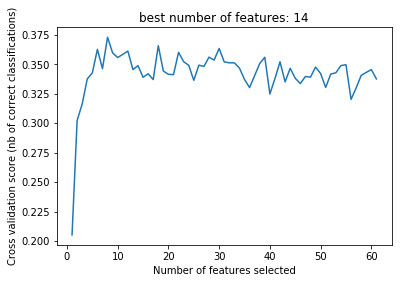

In [61]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f'best number of features: {n_features}')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(feature_selector.grid_scores_) + 1), feature_selector.grid_scores_)
plt.show()

In [62]:
# best_features = feature_importances.feature[:n_features]
best_features = feature_importances.feature[:30]
best_features

10                          meaneduc
22                     meaneduc_mean
110       phone_per_person_household
39                               age
12                         educ_rank
105                  female_per_room
11                          escolari
68                  utility_rank_sum
109      house_utility_vulnerability
104                    male_per_room
102                         rooms_pc
94                female_per_bedroom
92                   calc_dependency
93                 child_per_bedroom
29                     child_percent
95                  male_per_bedroom
119                     qmobilephone
103                   child_per_room
98     bedrooms_per_person_household
5                     rent_by_people
67                 material_rank_sum
28                     adult_percent
91                  dependency_count
30             r4t1_percent_in_total
66               house_material_good
2                        rent_by_dep
55                         wall_rank
4

In [63]:
%%time
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train[best_features], y_train)

report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.366 (std: 0.018)
Parameters: {'random_forest__max_depth': 25}

Model with rank: 2
Mean validation score: 0.366 (std: 0.019)
Parameters: {'random_forest__max_depth': 35}

Model with rank: 2
Mean validation score: 0.366 (std: 0.019)
Parameters: {'random_forest__max_depth': 40}

Wall time: 4.57 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

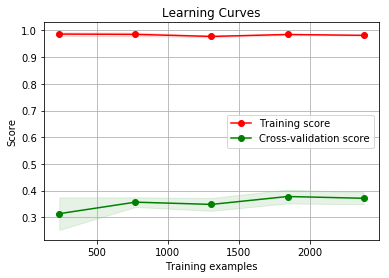

In [64]:
model = grid.best_estimator_
model.fit(X_train[best_features], y_train)
plot_learning_curve(model, 'Learning Curves', X_train[best_features], y_train, cv=kfold, scoring=f1_scorer)

## XGBoost with all features

In [66]:
pipeline = Pipeline(steps=[
    ('imputer', Imputer(strategy='mean')),
    ('feature_scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=1))])

param_grid = dict(xgb__max_depth=[30],
                  xgb__n_estimators=[100,300,500,1000,2000],
                  xgb__learning_rate=[0.01, 0.05, 0.10])

In [67]:
%%time
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=kfold, scoring=f1_scorer, n_jobs=-1)
grid.fit(X_train, y_train)

report_cv_scores(grid.cv_results_)

NameError: name 'report' is not defined

In [68]:
report_cv_scores(grid.cv_results_)

Model with rank: 1
Mean validation score: 0.321 (std: 0.081)
Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 30, 'xgb__n_estimators': 100}

Model with rank: 2
Mean validation score: 0.310 (std: 0.069)
Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 30, 'xgb__n_estimators': 2000}

Model with rank: 3
Mean validation score: 0.309 (std: 0.073)
Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 30, 'xgb__n_estimators': 1000}



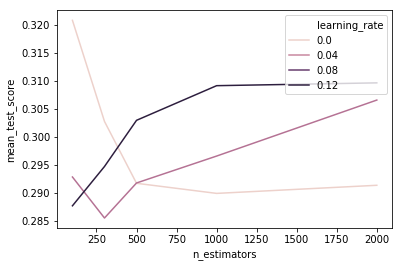

In [69]:
results = pd.DataFrame({'n_estimators':grid.cv_results_['param_xgb__n_estimators'].tolist(),
                        'learning_rate':grid.cv_results_['param_xgb__learning_rate'].tolist(), 
                        'mean_test_score':grid.cv_results_['mean_test_score']}) 

sns.lineplot(x='n_estimators', y='mean_test_score', hue='learning_rate', data=results)

## WARNING - this take a long time to run

In [70]:
%%time

X_transformed = transformer_pipeline.fit_transform(X_train)
xgb = XGBClassifier(random_state=1, max_depth=30,n_estimators=1000, learning_rate=0.10)
feature_selector = RFECV(xgb, step = 0.02, cv = kfold, scoring=f1_scorer, n_jobs = -1)

feature_selector.fit(X_transformed, y_train)
n_features = feature_selector.n_features_

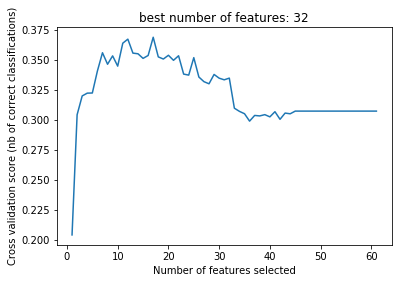

In [71]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.title(f'best number of features: {n_features}')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(feature_selector.grid_scores_) + 1), feature_selector.grid_scores_)
plt.show()

In [72]:
feature_selector.n_features_

32

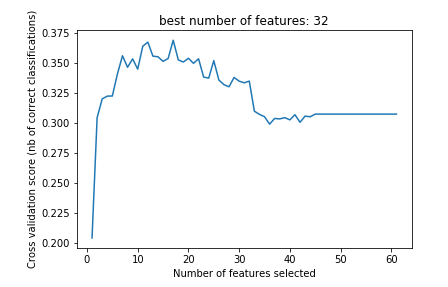

In [16]:
# TRY LGB
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [17]:
X_transformed = transformer_pipeline.fit_transform(X_train)

In [18]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_transformed, y_train, test_size=0.25)

In [19]:
%%time

params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}

model = lgb.LGBMClassifier(**params, objective = 'multiclass', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)

fit_params = {"eval_set": [(test_X, test_y)], 
              "early_stopping_rounds": 100, 
              "verbose": False} 
cv_score = cross_val_score(model, train_X, train_y, cv=kfold, scoring=f1_scorer, n_jobs=-1, fit_params=fit_params)
print(f'Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

Cross Validation F1 Score = 0.4064 with std = 0.0162
Wall time: 2min 16s
